#**CELLA 1 - Setup & Load Data**

In [ ]:
# ═══════════════════════════════════════════════════════════
# STATUS MODULE - EDA v2.0 (Sampled Dataset)
# ═══════════════════════════════════════════════════════════

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("="*80)
print("STATUS MODULE - EXPLORATORY DATA ANALYSIS v2.0")
print("="*80)

# ════════════════════════════════════════════════════════════
# LOAD SAMPLED DATASET
# ════════════════════════════════════════════════════════════

DATADIR = 'data/synth_set_level_v2'

print("\nLoading sampled datasets...")

df_users = pd.read_csv(f'{DATADIR}/users_sampled.csv')
df_sets = pd.read_csv(f'{DATADIR}/workout_sets_sampled.csv')
df_workouts = pd.read_csv(f'{DATADIR}/workouts_sampled.csv')

# Parse dates
df_sets['date'] = pd.to_datetime(df_sets['date'])
df_workouts['date'] = pd.to_datetime(df_workouts['date'])

print(f"[OK] Users: {len(df_users):,}")
print(f"[OK] Sets: {len(df_sets):,}")
print(f"[OK] Workouts: {len(df_workouts):,}")

# ════════════════════════════════════════════════════════════
# TARGET DISTRIBUTION
# ════════════════════════════════════════════════════════════

print("\n" + "-"*80)
print("TARGET DISTRIBUTION (experience_label)")
print("-"*80)

exp_counts = df_users['experience_label'].value_counts().sort_index()
for label, count in exp_counts.items():
    pct = count / len(df_users) * 100
    print(f"{label:12s}: {count:3d} ({pct:5.1f}%)")

# Imbalance ratio
max_class = exp_counts.max()
min_class = exp_counts.min()
imbalance_ratio = max_class / min_class

print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

if imbalance_ratio > 3:
    print("[!]  Class imbalance detected (>3:1)")
else:
    print("[OK] Classes balanced")

print("="*80)


STATUS MODULE - EXPLORATORY DATA ANALYSIS v2.0

Loading sampled datasets...
[OK] Users: 510
[OK] Sets: 1,566,944
[OK] Workouts: 106,571

--------------------------------------------------------------------------------
TARGET DISTRIBUTION (experience_label)
--------------------------------------------------------------------------------
Advanced    : 170 ( 33.3%)
Beginner    : 170 ( 33.3%)
Intermediate: 170 ( 33.3%)

Imbalance ratio: 1.00:1
[OK] Classes balanced


#**CELLA 2 - Compute User-Level Aggregations**

In [ ]:
# ═══════════════════════════════════════════════════════════
# USER-LEVEL FEATURE AGGREGATIONS
# ═══════════════════════════════════════════════════════════

print("="*80)
print("COMPUTING USER-LEVEL AGGREGATIONS")
print("="*80)

# ════════════════════════════════════════════════════════════
# Basic Stats per User
# ════════════════════════════════════════════════════════════

print("\n1. Basic workout statistics...")

user_agg_basic = df_sets.groupby('user_id').agg({
    'load_done_kg': ['mean', 'std', 'min', 'max'],
    'reps_done': ['mean', 'std'],
    'rpe_done': ['mean', 'std'],
    'set_id': 'count'  # Total sets
}).reset_index()

# Flatten columns
user_agg_basic.columns = ['user_id', 'load_mean', 'load_std', 'load_min', 'load_max',
                          'reps_mean', 'reps_std', 'rpe_mean', 'rpe_std', 'total_sets']

print(f"[OK] Aggregated {len(user_agg_basic)} users")

# ════════════════════════════════════════════════════════════
# ACWR Stats
# ════════════════════════════════════════════════════════════

print("2. ACWR statistics...")

user_acwr = df_sets.groupby('user_id').agg({
    'acwr': 'mean'
}).reset_index()
user_acwr.columns = ['user_id', 'acwr_mean']

# Spike weeks count
spike_counts = df_sets[df_sets['week_type'] == 'spike'].groupby('user_id').size().reset_index(name='spike_weeks_count')

# Merge
user_agg = user_agg_basic.merge(user_acwr, on='user_id', how='left')
user_agg = user_agg.merge(spike_counts, on='user_id', how='left')
user_agg['spike_weeks_count'] = user_agg['spike_weeks_count'].fillna(0).astype(int)

print(f"[OK] ACWR and spike counts added")

# ════════════════════════════════════════════════════════════
# Workout Frequency
# ════════════════════════════════════════════════════════════

print("3. Workout frequency...")

# Count workouts per user
workout_counts = df_workouts.groupby('user_id').size().reset_index(name='total_workouts')

# Calculate duration
user_duration = df_workouts.groupby('user_id')['date'].agg(['min', 'max']).reset_index()
user_duration['duration_days'] = (user_duration['max'] - user_duration['min']).dt.days + 1
user_duration['duration_weeks'] = user_duration['duration_days'] / 7.0

# Observed frequency (workouts/week)
workout_counts = workout_counts.merge(user_duration[['user_id', 'duration_weeks']], on='user_id')
workout_counts['observed_freq_weekly'] = workout_counts['total_workouts'] / workout_counts['duration_weeks']

# Merge
user_agg = user_agg.merge(
    workout_counts[['user_id', 'observed_freq_weekly']],
    on='user_id',
    how='left'
)

print(f"[OK] Frequency calculated")

# ════════════════════════════════════════════════════════════
# Skip Rate & Consistency (from workouts)
# ════════════════════════════════════════════════════════════

print("4. Skip rate and consistency...")

skip_stats = df_workouts.groupby('user_id')['workout_status'].apply(
    lambda x: (x == 'skipped').sum() / len(x) if len(x) > 0 else 0.0
).reset_index(name='skip_rate')

user_agg = user_agg.merge(skip_stats, on='user_id', how='left')

# Consistency from df_users
user_agg = user_agg.merge(
    df_users[['user_id', 'consistency_score', 'experience_label']],
    on='user_id',
    how='left'
)

print(f"[OK] Skip rate and consistency added")

# ════════════════════════════════════════════════════════════
# Load Progression (Slope)
# ════════════════════════════════════════════════════════════

print("5. Load progression (slope regression)...")

def calculate_load_progression(user_df):
    """Calculate slope of load over time (linear regression)"""
    if len(user_df) < 10:
        return 0.0

    user_df = user_df.sort_values('date').reset_index(drop=True)
    user_df = user_df.dropna(subset=['load_done_kg'])

    if len(user_df) < 10:
        return 0.0

    # Time index (days from start)
    user_df['days_from_start'] = (user_df['date'] - user_df['date'].min()).dt.days

    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        user_df['days_from_start'],
        user_df['load_done_kg']
    )

    # Normalize: slope per 30 days (monthly rate)
    slope_monthly = slope * 30

    # Convert to multiplier (1.0 = no change, 1.1 = +10% per month)
    if intercept > 0:
        progression = 1.0 + (slope_monthly / intercept)
    else:
        progression = 1.0

    return float(np.clip(progression, 0.5, 2.0))

load_progressions = []

for uid in user_agg['user_id']:
    user_sets = df_sets[df_sets['user_id'] == uid]
    prog = calculate_load_progression(user_sets)
    load_progressions.append({'user_id': uid, 'load_progression': prog})

load_prog_df = pd.DataFrame(load_progressions)
user_agg = user_agg.merge(load_prog_df, on='user_id', how='left')

print(f"[OK] Load progression calculated")

# ════════════════════════════════════════════════════════════
# Composite Features
# ════════════════════════════════════════════════════════════

print("6. Composite features...")

user_agg['volume_score'] = user_agg['total_sets'] * user_agg['observed_freq_weekly']
user_agg['intensity_score'] = user_agg['load_mean'] * user_agg['reps_mean']
user_agg['rpe_volume_interaction'] = user_agg['rpe_mean'] * user_agg['reps_mean']

print(f"[OK] Composite features added")

# ════════════════════════════════════════════════════════════
# FINAL DATASET
# ════════════════════════════════════════════════════════════

print("\n" + "-"*80)
print("FINAL AGGREGATED DATASET")
print("-"*80)
print(f"[OK] Shape: {user_agg.shape}")
print(f"[OK] Features: {user_agg.shape[1] - 2} (excluding user_id, experience_label)")
print(f"[OK] Users: {len(user_agg)}")

print("\nColumn list:")
print(user_agg.columns.tolist())

print("\nPreview (first 5):")
print(user_agg.head())

print("="*80)


COMPUTING USER-LEVEL AGGREGATIONS

1. Basic workout statistics...
[OK] Aggregated 510 users
2. ACWR statistics...
[OK] ACWR and spike counts added
3. Workout frequency...
[OK] Frequency calculated
4. Skip rate and consistency...
[OK] Skip rate and consistency added
5. Load progression (slope regression)...
[OK] Load progression calculated
6. Composite features...
[OK] Composite features added

--------------------------------------------------------------------------------
FINAL AGGREGATED DATASET
--------------------------------------------------------------------------------
[OK] Shape: (510, 20)
[OK] Features: 18 (excluding user_id, experience_label)
[OK] Users: 510

Column list:
['user_id', 'load_mean', 'load_std', 'load_min', 'load_max', 'reps_mean', 'reps_std', 'rpe_mean', 'rpe_std', 'total_sets', 'acwr_mean', 'spike_weeks_count', 'observed_freq_weekly', 'skip_rate', 'consistency_score', 'experience_label', 'load_progression', 'volume_score', 'intensity_score', 'rpe_volume_intera

#**CELLA 3 - Statistiche Descrittive per Experience Level**

In [ ]:
# ═══════════════════════════════════════════════════════════
# DESCRIPTIVE STATISTICS per EXPERIENCE LEVEL
# ═══════════════════════════════════════════════════════════

print("="*80)
print("DESCRIPTIVE STATISTICS per EXPERIENCE LEVEL")
print("="*80)

# Feature numeriche chiave da analizzare
key_features = [
    'load_mean', 'reps_mean', 'rpe_mean', 'total_sets',
    'acwr_mean', 'spike_weeks_count', 'load_progression',
    'observed_freq_weekly', 'skip_rate', 'consistency_score'
]

for feat in key_features:
    print(f"\n{'='*80}")
    print(f"FEATURE: {feat}")
    print("="*80)

    stats_by_exp = user_agg.groupby('experience_label')[feat].agg([
        'count', 'mean', 'std', 'min',
        ('q25', lambda x: x.quantile(0.25)),
        ('median', 'median'),
        ('q75', lambda x: x.quantile(0.75)),
        'max'
    ]).round(2)

    print(stats_by_exp)

    # Cohen's d (Beginner vs Advanced)
    beg_vals = user_agg[user_agg['experience_label'] == 'Beginner'][feat].dropna()
    adv_vals = user_agg[user_agg['experience_label'] == 'Advanced'][feat].dropna()

    if len(beg_vals) > 0 and len(adv_vals) > 0:
        pooled_std = np.sqrt(((len(beg_vals)-1)*beg_vals.std()**2 +
                              (len(adv_vals)-1)*adv_vals.std()**2) /
                             (len(beg_vals) + len(adv_vals) - 2))

        cohens_d = abs(beg_vals.mean() - adv_vals.mean()) / pooled_std if pooled_std > 0 else 0.0

        print(f"\n[OK] Cohen's d (Beginner vs Advanced): {cohens_d:.3f}")

        if cohens_d < 0.2:
            print("  -> Effetto TRASCURABILE (feature NON discrimina)")
        elif cohens_d < 0.5:
            print("  -> Effetto PICCOLO")
        elif cohens_d < 0.8:
            print("  -> Effetto MEDIO")
        else:
            print("  -> Effetto GRANDE (feature discrimina BENE)")

print("\n" + "="*80)
print("[OK] Descriptive statistics complete")
print("="*80)


DESCRIPTIVE STATISTICS per EXPERIENCE LEVEL

FEATURE: load_mean
                  count   mean    std    min    q25  median    q75     max
experience_label                                                          
Advanced            170  68.69  23.55  34.16  52.10   60.56  78.02  144.41
Beginner            170  19.70   1.57  15.93  18.76   19.66  20.51   25.57
Intermediate        170  33.45   5.66  22.75  29.75   31.94  36.10   61.31

[OK] Cohen's d (Beginner vs Advanced): 2.935
  -> Effetto GRANDE (feature discrimina BENE)

FEATURE: reps_mean
                  count  mean   std   min   q25  median   q75   max
experience_label                                                   
Advanced            170  8.68  0.06  8.56  8.64    8.66  8.69  8.86
Beginner            170  8.96  0.10  8.62  8.89    8.95  9.02  9.21
Intermediate        170  8.72  0.09  8.55  8.66    8.70  8.79  9.04

[OK] Cohen's d (Beginner vs Advanced): 3.302
  -> Effetto GRANDE (feature discrimina BENE)

FEATURE: rpe_mea

#**CELLA 4 - Correlation Matrix (Verifica Leakage)**

CORRELATION MATRIX - LEAKAGE CHECK

--------------------------------------------------------------------------------
CORRELATION con TARGET (experience_label)
--------------------------------------------------------------------------------

Top correlations (absolute value):

consistency_score        : +1.000
  [!]  HIGH LEAKAGE RISK (|r| > 0.85)
skip_rate                : -0.839
  [MODERATE] MODERATE correlation
load_mean                : +0.803
  [MODERATE] MODERATE correlation
intensity_score          : +0.796
  [MODERATE] MODERATE correlation
reps_mean                : -0.761
  [MODERATE] MODERATE correlation
rpe_volume_interaction   : -0.756
  [MODERATE] MODERATE correlation
total_sets               : +0.755
  [MODERATE] MODERATE correlation
acwr_mean                : -0.691
  [OK] Good discriminative power
rpe_mean                 : -0.673
  [OK] Good discriminative power
volume_score             : +0.668
  [OK] Good discriminative power
spike_weeks_count        : +0.450
  [OK] G

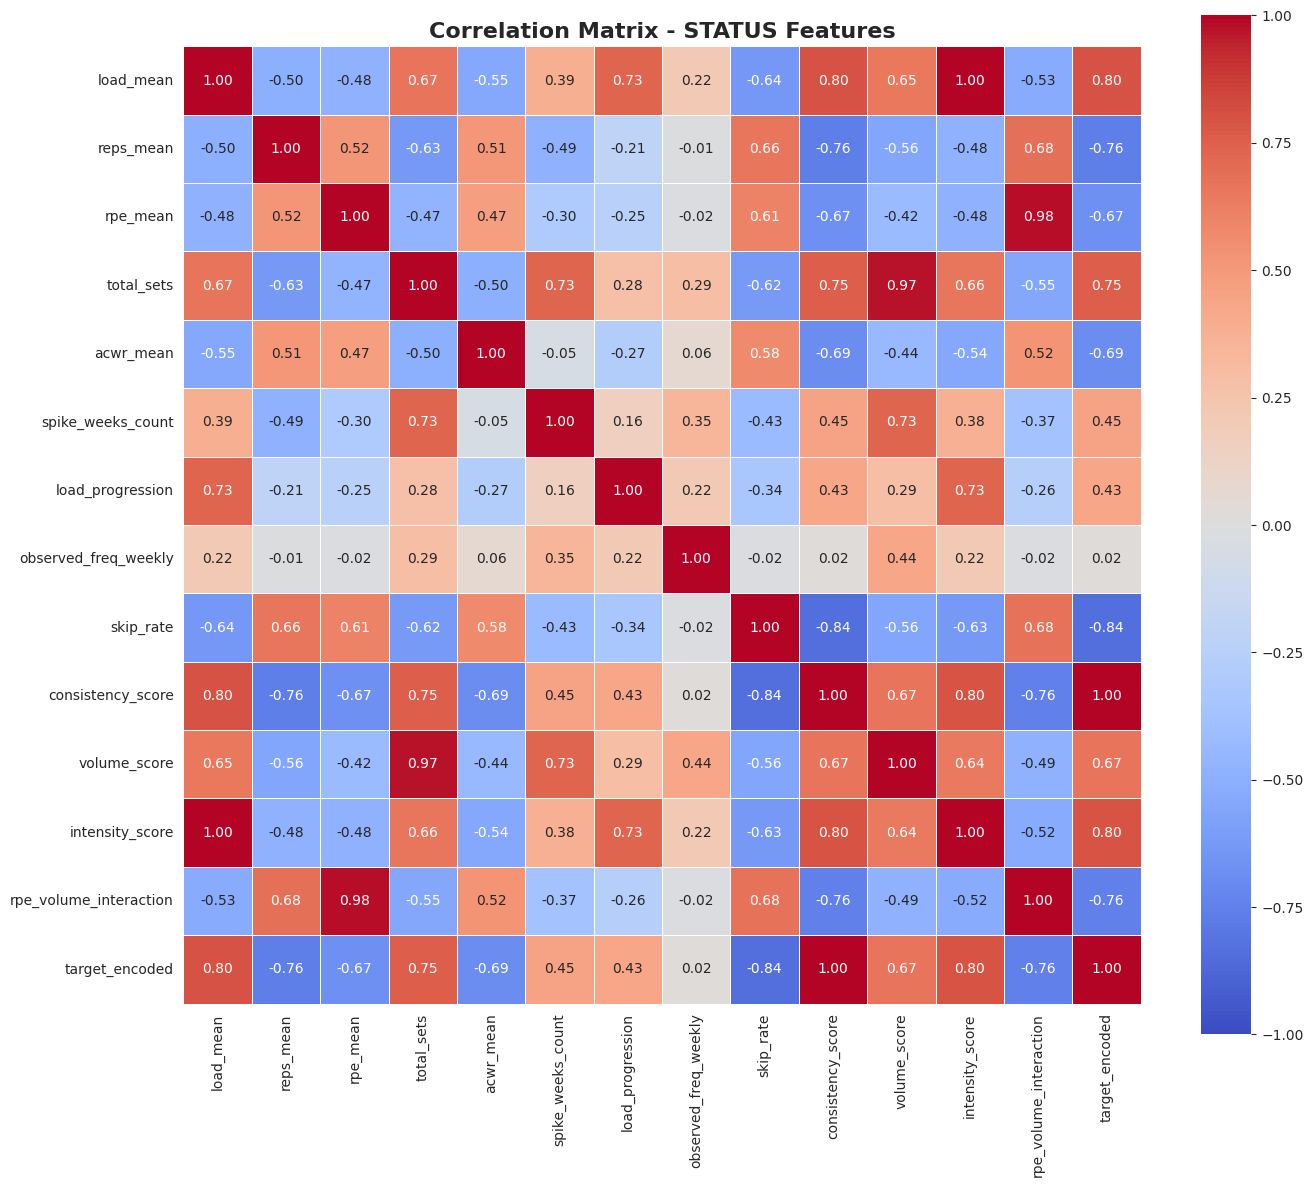

[OK] Heatmap saved: correlation_matrix_STATUS_v2.png

LEAKAGE COMPARISON (v1.0 vs v2.0)

Expected results:
  v1.0 load_mean correlation: ~0.96 (HIGH LEAKAGE)
  v2.0 load_mean correlation: 0.803
  [OK] LEAKAGE REDUCED (v2.0 experience-aware patterns working!)


In [ ]:
# ═══════════════════════════════════════════════════════════
# CORRELATION MATRIX - LEAKAGE CHECK
# ═══════════════════════════════════════════════════════════

print("="*80)
print("CORRELATION MATRIX - LEAKAGE CHECK")
print("="*80)

# Target encoding (per correlation numerica)
target_encoding = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
user_agg['target_encoded'] = user_agg['experience_label'].map(target_encoding)

# Feature per correlation
corr_features = [
    'load_mean', 'reps_mean', 'rpe_mean', 'total_sets',
    'acwr_mean', 'spike_weeks_count', 'load_progression',
    'observed_freq_weekly', 'skip_rate', 'consistency_score',
    'volume_score', 'intensity_score', 'rpe_volume_interaction',
    'target_encoded'
]

corr_matrix = user_agg[corr_features].corr()

# ════════════════════════════════════════════════════════════
# Correlation con Target
# ════════════════════════════════════════════════════════════

print("\n" + "-"*80)
print("CORRELATION con TARGET (experience_label)")
print("-"*80)

target_corr = corr_matrix['target_encoded'].drop('target_encoded').sort_values(
    key=abs, ascending=False
)

print("\nTop correlations (absolute value):\n")
for feat, corr_val in target_corr.items():
    print(f"{feat:25s}: {corr_val:+.3f}")

    # Flag leakage risk
    if abs(corr_val) > 0.85:
        print(f"  [!]  HIGH LEAKAGE RISK (|r| > 0.85)")
    elif abs(corr_val) > 0.70:
        print(f"  [MODERATE] MODERATE correlation")
    elif abs(corr_val) > 0.40:
        print(f"  [OK] Good discriminative power")
    else:
        print(f"  [SAFE] Weak correlation ")

# ════════════════════════════════════════════════════════════
# Heatmap Visualization
# ════════════════════════════════════════════════════════════

print("\n" + "-"*80)
print("CORRELATION HEATMAP")
print("-"*80)

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5
)
plt.title('Correlation Matrix - STATUS Features', fontsize=16, weight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix_STATUS_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Heatmap saved: correlation_matrix_STATUS_v2.png")

# ════════════════════════════════════════════════════════════
# Comparison v1.0 vs v2.0 (se disponibile)
# ════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("LEAKAGE COMPARISON (v1.0 vs v2.0)")
print("="*80)

print("\nExpected results:")
print("  v1.0 load_mean correlation: ~0.96 (HIGH LEAKAGE)")
print(f"  v2.0 load_mean correlation: {target_corr.get('load_mean', 0):.3f}")

if abs(target_corr.get('load_mean', 0)) < 0.85:
    print("  [OK] LEAKAGE REDUCED (v2.0 experience-aware patterns working!)")
else:
    print("  [!]  Still high correlation (need further investigation)")

print("="*80)


# **CELLA 5 - FEATURE SELECTION**

In [ ]:
# ═══════════════════════════════════════════════════════════
# FEATURE SELECTION v2.2
# ═══════════════════════════════════════════════════════════

print("="*80)
print("FEATURE SELECTION v2.2 (LEAKAGE-FREE)")
print("="*80)

# ════════════════════════════════════════════════════════════
# SELECTED FEATURES (7 features)
# ════════════════════════════════════════════════════════════

SELECTED_FEATURES = [
    'reps_mean',                  # Cohen's d: 3.302, corr: -0.761
    'rpe_mean',                   # Cohen's d: 2.211, corr: -0.673
    'total_sets',                 # Cohen's d: 2.612, corr: +0.755
    'acwr_mean',                  # Cohen's d: 2.162, corr: -0.691
    'spike_weeks_count',          # Cohen's d: 1.264, corr: +0.450
    'load_progression',           # Cohen's d: 1.000, corr: +0.432
    'skip_rate'                   # Cohen's d: 3.657, corr: -0.839
    # REMOVED: observed_freq_weekly (Cohen's d: 0.041, non discriminante)
    # REMOVED: consistency_score (correlation: 1.000, LEAKAGE!)
    # REMOVED: rpe_volume_interaction (collineare con rpe_mean × reps_mean)
]

print(f"\n[OK] Selected features: {len(SELECTED_FEATURES)}")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    print(f"  {i}. {feat}")

# ════════════════════════════════════════════════════════════
# VERIFY NO HIGH LEAKAGE
# ════════════════════════════════════════════════════════════

print("\n" + "-"*80)
print("LEAKAGE VERIFICATION")
print("-"*80)

for feat in SELECTED_FEATURES:
    corr_val = corr_matrix.loc[feat, 'target_encoded']

    status = "[OK] SAFE" if abs(corr_val) < 0.85 else "[!] HIGH"
    print(f"{feat:25s}: {corr_val:+.3f}  {status}")

# Check max correlation
max_corr = max(abs(corr_matrix.loc[feat, 'target_encoded']) for feat in SELECTED_FEATURES)
print(f"\n[OK] Max absolute correlation: {max_corr:.3f}")

if max_corr < 0.85:
    print("  [OK] ALL FEATURES BELOW LEAKAGE THRESHOLD (0.85)")
else:
    print("  [!] Some features above threshold - review needed")

# ════════════════════════════════════════════════════════════
# FEATURE IMPORTANCE (Cohen's d ranking)
# ════════════════════════════════════════════════════════════

print("\n" + "-"*80)
print("FEATURE DISCRIMINATIVE POWER (Cohen's d)")
print("-"*80)

cohens_ranking = []
for feat in SELECTED_FEATURES:
    beg = user_agg[user_agg['experience_label'] == 'Beginner'][feat].dropna()
    adv = user_agg[user_agg['experience_label'] == 'Advanced'][feat].dropna()

    pooled_std = np.sqrt(((len(beg)-1)*beg.std()**2 +
                          (len(adv)-1)*adv.std()**2) / (len(beg)+len(adv)-2))
    cohens_d = abs(beg.mean() - adv.mean()) / pooled_std if pooled_std > 0 else 0.0

    cohens_ranking.append({
        'Feature': feat,
        'Cohens_d': cohens_d,
        'Correlation': corr_matrix.loc[feat, 'target_encoded']
    })

cohens_df = pd.DataFrame(cohens_ranking).sort_values('Cohens_d', ascending=False)

print("\nRanked by discriminative power:\n")
print(cohens_df.to_string(index=False))

print("\n" + "="*80)
print("[OK] Feature Selection v2.2 Complete")
print(f"[OK] Final feature count: {len(SELECTED_FEATURES)}")
print("[OK] Ready for Modeling")
print("="*80)


FEATURE SELECTION v2.2 (LEAKAGE-FREE)

[OK] Selected features: 7
  1. reps_mean
  2. rpe_mean
  3. total_sets
  4. acwr_mean
  5. spike_weeks_count
  6. load_progression
  7. skip_rate

--------------------------------------------------------------------------------
LEAKAGE VERIFICATION
--------------------------------------------------------------------------------
reps_mean                : -0.761  [OK] SAFE
rpe_mean                 : -0.673  [OK] SAFE
total_sets               : +0.755  [OK] SAFE
acwr_mean                : -0.691  [OK] SAFE
spike_weeks_count        : +0.450  [OK] SAFE
load_progression         : +0.432  [OK] SAFE
skip_rate                : -0.839  [OK] SAFE

[OK] Max absolute correlation: 0.839
  [OK] ALL FEATURES BELOW LEAKAGE THRESHOLD (0.85)

--------------------------------------------------------------------------------
FEATURE DISCRIMINATIVE POWER (Cohen's d)
--------------------------------------------------------------------------------

Ranked by discriminati

#**CELLA 6 - Distribuzione Feature (Histograms Stratificati)**

FEATURE DISTRIBUTIONS - HISTOGRAMS


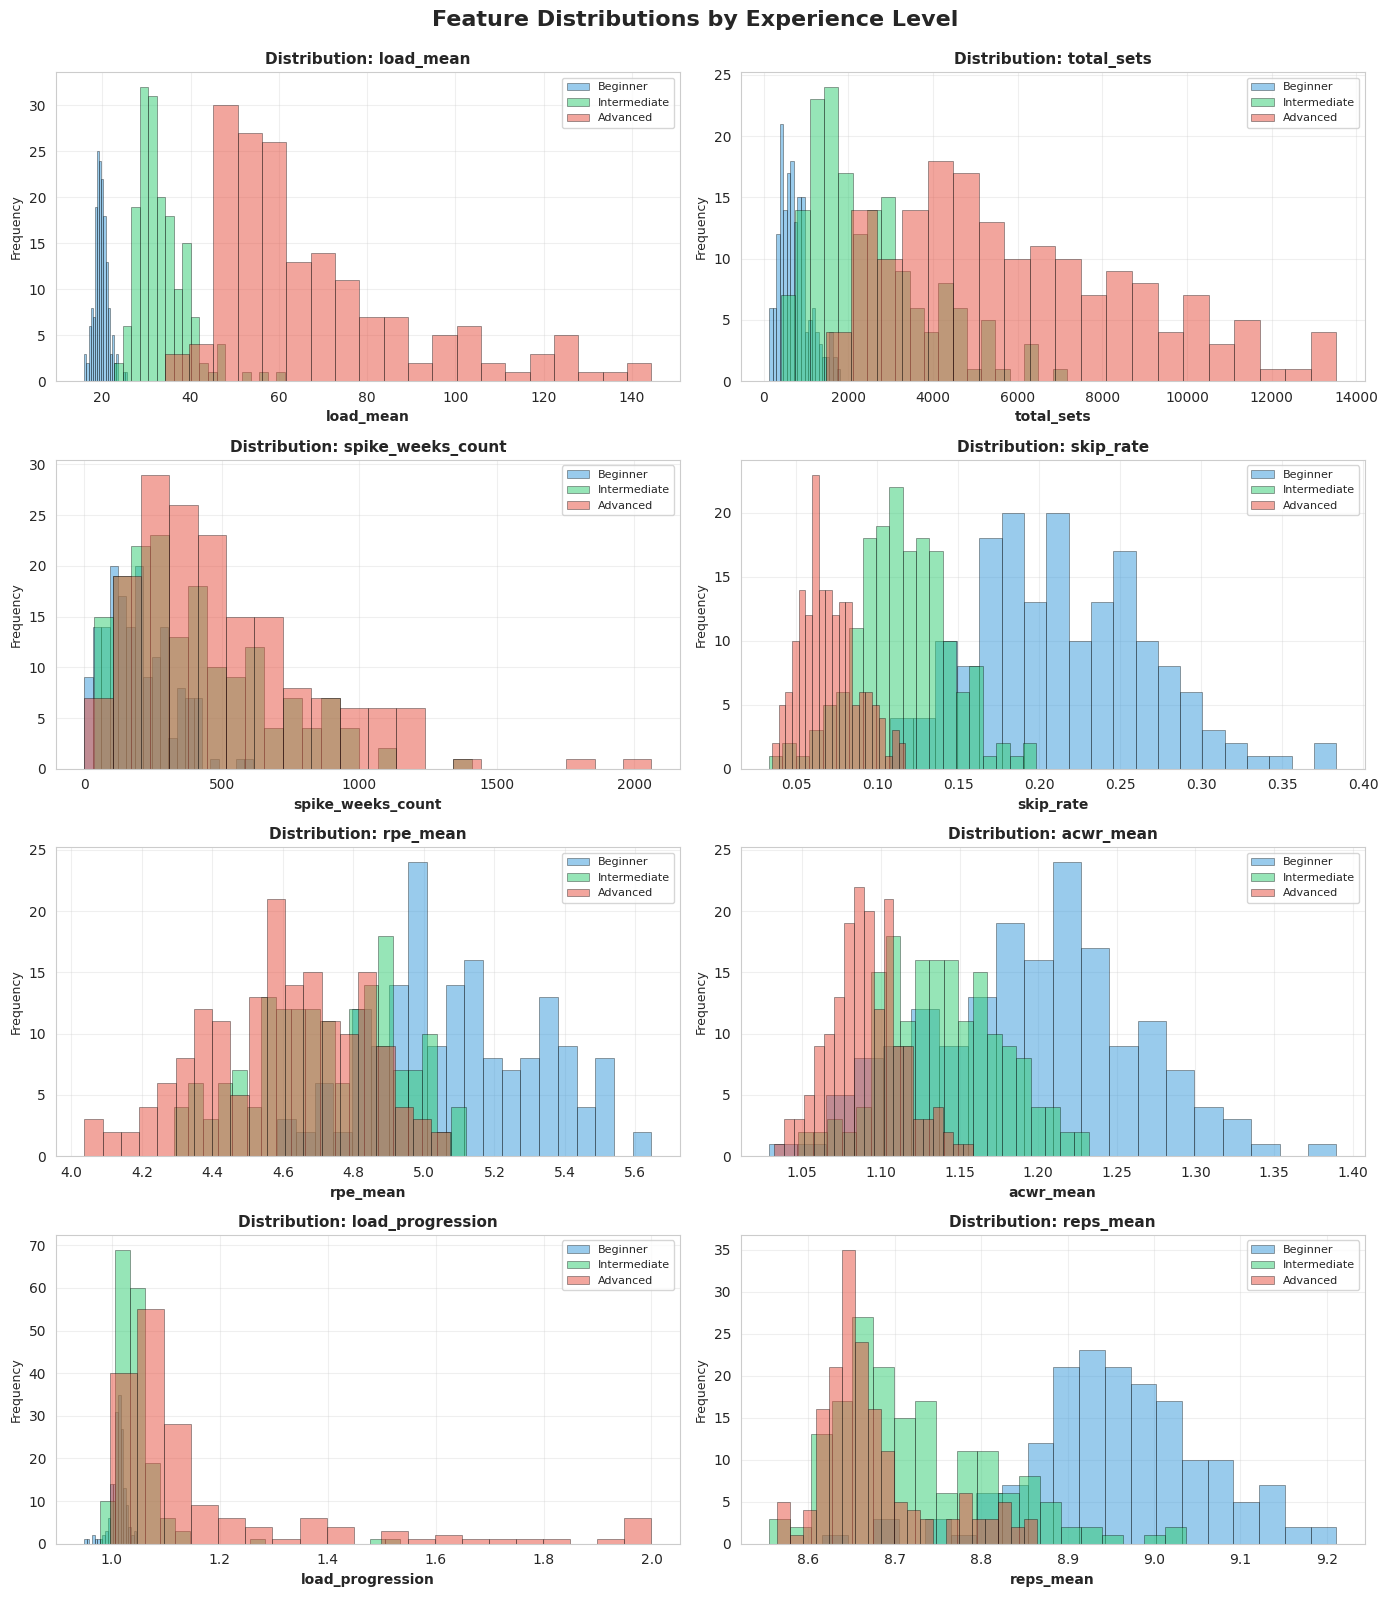

[OK] Histograms saved: feature_distributions_STATUS_v2.png


In [ ]:
# ═══════════════════════════════════════════════════════════
# FEATURE DISTRIBUTIONS - HISTOGRAMS (Stratified by Experience)
# ═══════════════════════════════════════════════════════════

print("="*80)
print("FEATURE DISTRIBUTIONS - HISTOGRAMS")
print("="*80)

# Feature chiave per distribution analysis
dist_features = [
    'load_mean', 'total_sets', 'spike_weeks_count', 'skip_rate',
    'rpe_mean', 'acwr_mean', 'load_progression', 'reps_mean'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 16))
axes = axes.flatten()

colors = {'Beginner': '#3498db', 'Intermediate': '#2ecc71', 'Advanced': '#e74c3c'}

for idx, feat in enumerate(dist_features):
    ax = axes[idx]

    # Histogram per experience level (overlayed)
    for exp_label in ['Beginner', 'Intermediate', 'Advanced']:
        data = user_agg[user_agg['experience_label'] == exp_label][feat].dropna()

        ax.hist(data, bins=20, alpha=0.5, label=exp_label,
                color=colors[exp_label], edgecolor='black', linewidth=0.5)

    ax.set_xlabel(feat, fontsize=10, weight='bold')
    ax.set_ylabel('Frequency', fontsize=9)
    ax.set_title(f'Distribution: {feat}', fontsize=11, weight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions by Experience Level',
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.savefig('feature_distributions_STATUS_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Histograms saved: feature_distributions_STATUS_v2.png")
print("="*80)


#**CELLA 7 - Violin Plots (Distribuzione + Densità)**

VIOLIN PLOTS - Distribution Density


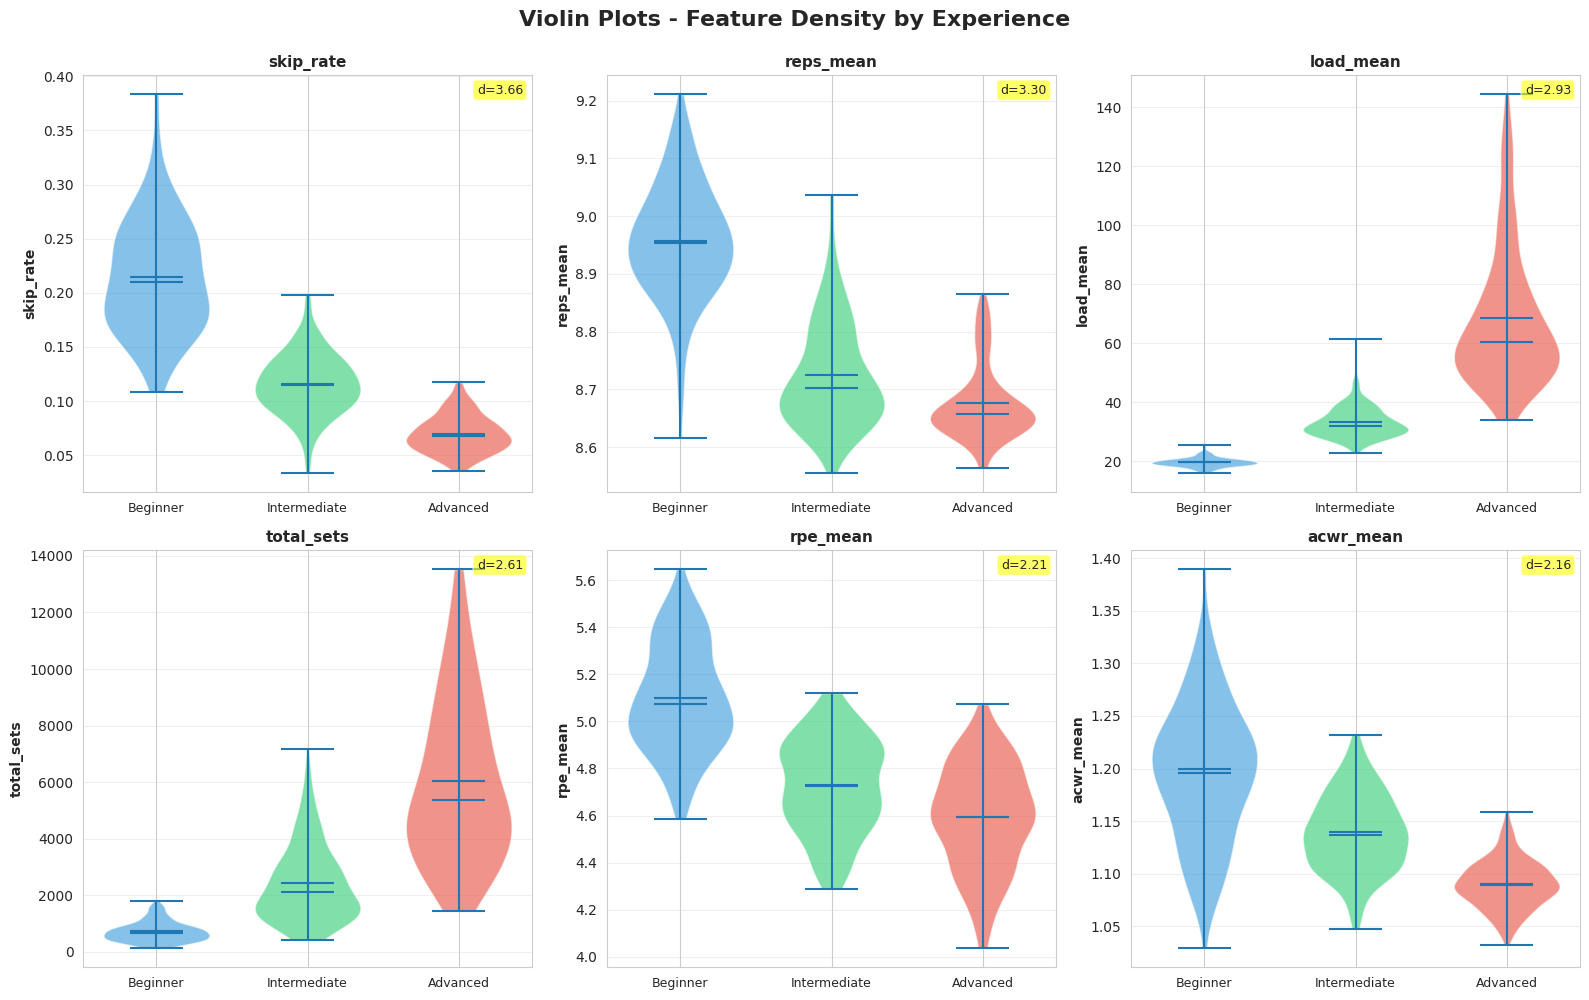

[OK] Violin plots saved: violin_plots_STATUS_v2.png


In [ ]:
# ═══════════════════════════════════════════════════════════
# VIOLIN PLOTS - Distribution Density by Experience
# ═══════════════════════════════════════════════════════════

print("="*80)
print("VIOLIN PLOTS - Distribution Density")
print("="*80)

# Top 6 discriminative features
violin_features = [
    'skip_rate', 'reps_mean', 'load_mean',
    'total_sets', 'rpe_mean', 'acwr_mean'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feat in enumerate(violin_features):
    ax = axes[idx]

    # Violin plot con quartili
    parts = ax.violinplot(
        [user_agg[user_agg['experience_label'] == exp][feat].dropna().values
         for exp in ['Beginner', 'Intermediate', 'Advanced']],
        positions=[1, 2, 3],
        showmeans=True,
        showmedians=True,
        widths=0.7
    )

    # Color by experience
    colors_list = ['#3498db', '#2ecc71', '#e74c3c']
    for pc, color in zip(parts['bodies'], colors_list):
        pc.set_facecolor(color)
        pc.set_alpha(0.6)

    # Styling
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Beginner', 'Intermediate', 'Advanced'], fontsize=9)
    ax.set_ylabel(feat, fontsize=10, weight='bold')
    ax.set_title(f'{feat}', fontsize=11, weight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add Cohen's d annotation
    beg = user_agg[user_agg['experience_label'] == 'Beginner'][feat].dropna()
    adv = user_agg[user_agg['experience_label'] == 'Advanced'][feat].dropna()

    if len(beg) > 0 and len(adv) > 0:
        pooled_std = np.sqrt(((len(beg)-1)*beg.std()**2 +
                              (len(adv)-1)*adv.std()**2) / (len(beg)+len(adv)-2))
        cohens_d = abs(beg.mean() - adv.mean()) / pooled_std if pooled_std > 0 else 0.0

        ax.text(0.98, 0.98, f"d={cohens_d:.2f}",
                transform=ax.transAxes, fontsize=9, va='top', ha='right',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.6))

plt.suptitle('Violin Plots - Feature Density by Experience',
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.savefig('violin_plots_STATUS_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Violin plots saved: violin_plots_STATUS_v2.png")
print("="*80)


#**CELLA 9 - Comparison Plots (Beginner vs Advanced)**

COMPARISON PLOTS - Beginner vs Advanced


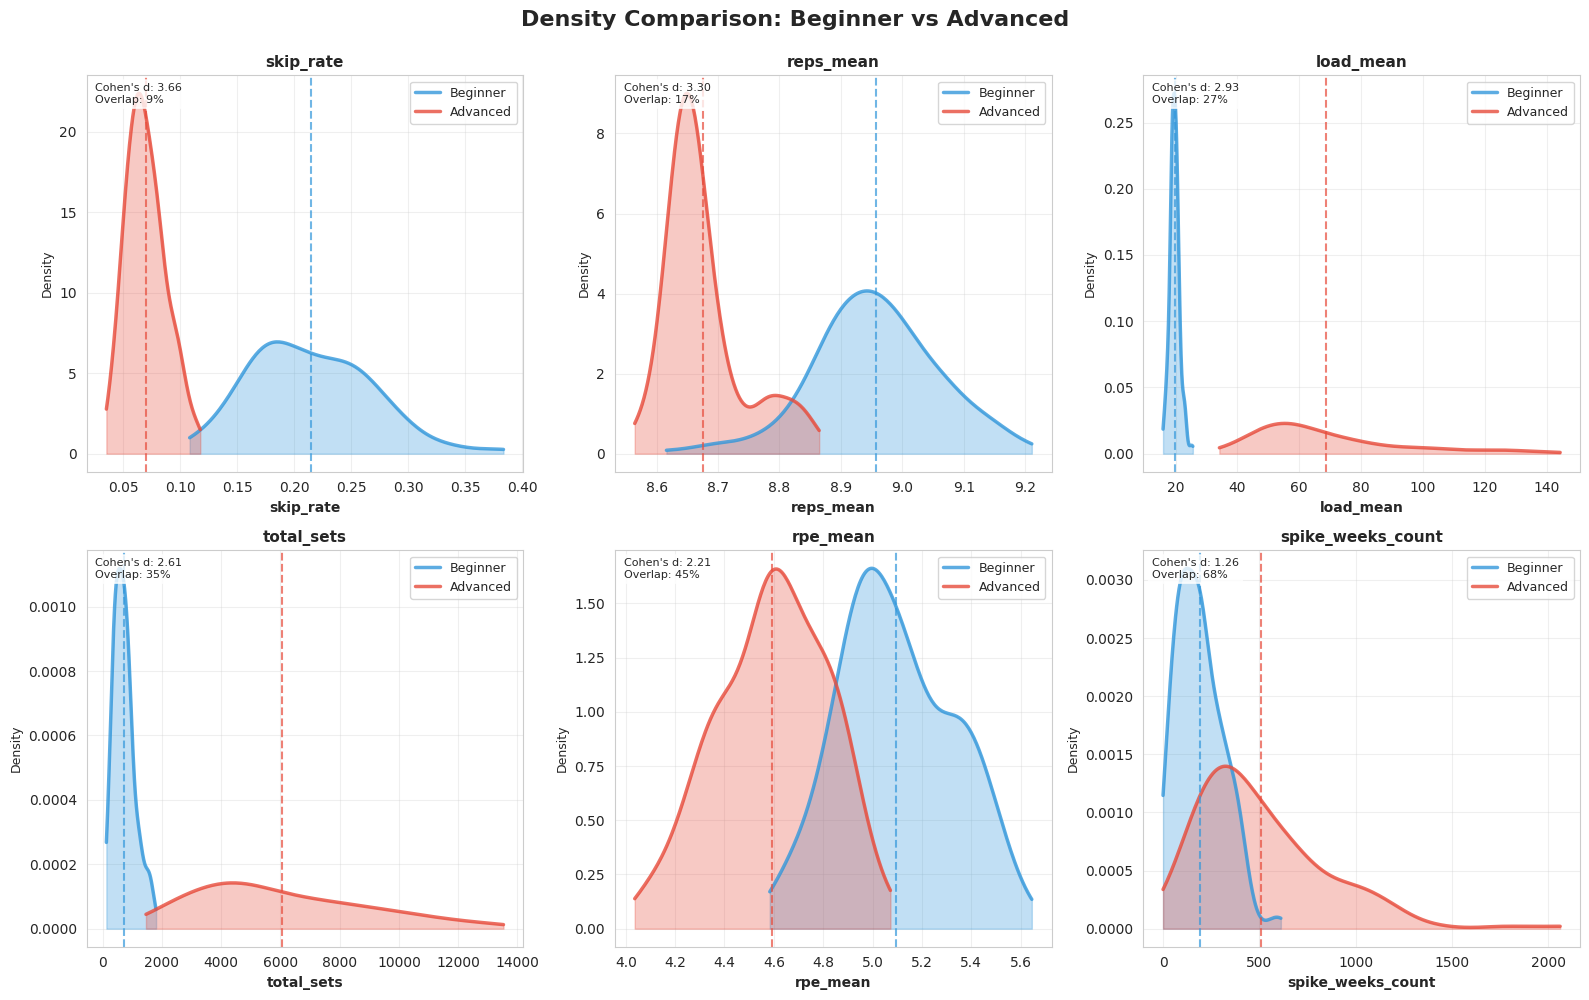

[OK] Comparison plots saved: comparison_beginner_advanced_STATUS_v2.png


In [ ]:
# ═══════════════════════════════════════════════════════════
# COMPARISON PLOTS - Beginner vs Advanced (Detailed)
# ═══════════════════════════════════════════════════════════

print("="*80)
print("COMPARISON PLOTS - Beginner vs Advanced")
print("="*80)

# Select top discriminative features
compare_features = [
    'skip_rate', 'reps_mean', 'load_mean',
    'total_sets', 'rpe_mean', 'spike_weeks_count'
]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feat in enumerate(compare_features):
    ax = axes[idx]

    # Data
    beg_data = user_agg[user_agg['experience_label'] == 'Beginner'][feat].dropna()
    adv_data = user_agg[user_agg['experience_label'] == 'Advanced'][feat].dropna()

    # KDE plot (smoothed histogram)
    from scipy.stats import gaussian_kde

    # Beginner
    if len(beg_data) > 1:
        kde_beg = gaussian_kde(beg_data)
        x_beg = np.linspace(beg_data.min(), beg_data.max(), 200)
        ax.plot(x_beg, kde_beg(x_beg), color='#3498db', linewidth=2.5,
                label='Beginner', alpha=0.8)
        ax.fill_between(x_beg, kde_beg(x_beg), alpha=0.3, color='#3498db')

    # Advanced
    if len(adv_data) > 1:
        kde_adv = gaussian_kde(adv_data)
        x_adv = np.linspace(adv_data.min(), adv_data.max(), 200)
        ax.plot(x_adv, kde_adv(x_adv), color='#e74c3c', linewidth=2.5,
                label='Advanced', alpha=0.8)
        ax.fill_between(x_adv, kde_adv(x_adv), alpha=0.3, color='#e74c3c')

    # Means
    ax.axvline(beg_data.mean(), color='#3498db', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axvline(adv_data.mean(), color='#e74c3c', linestyle='--', linewidth=1.5, alpha=0.7)

    ax.set_xlabel(feat, fontsize=10, weight='bold')
    ax.set_ylabel('Density', fontsize=9)
    ax.set_title(f'{feat}', fontsize=11, weight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)

    # Cohen's d annotation
    pooled_std = np.sqrt(((len(beg_data)-1)*beg_data.std()**2 +
                          (len(adv_data)-1)*adv_data.std()**2) / (len(beg_data)+len(adv_data)-2))
    cohens_d = abs(beg_data.mean() - adv_data.mean()) / pooled_std if pooled_std > 0 else 0.0

    ax.text(0.02, 0.98, f"Cohen's d: {cohens_d:.2f}\nOverlap: {100*(1-cohens_d/4):.0f}%",
            transform=ax.transAxes, fontsize=8, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Density Comparison: Beginner vs Advanced',
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.savefig('comparison_beginner_advanced_STATUS_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Comparison plots saved: comparison_beginner_advanced_STATUS_v2.png")
print("="*80)


#**CELLA 10 - Categorical Analysis (Workout Patterns)**

CATEGORICAL ANALYSIS - Workout Patterns

Merging experience_label to sets data...
[OK] Merged: 1,566,944 sets with experience labels

1. Week Type Distribution by Experience...

Week Type Distribution (%):

week_type         deload  normal  spike
experience_label                       
Advanced             5.4    86.1    8.4
Beginner             2.0    71.5   26.5
Intermediate         3.6    79.9   16.5


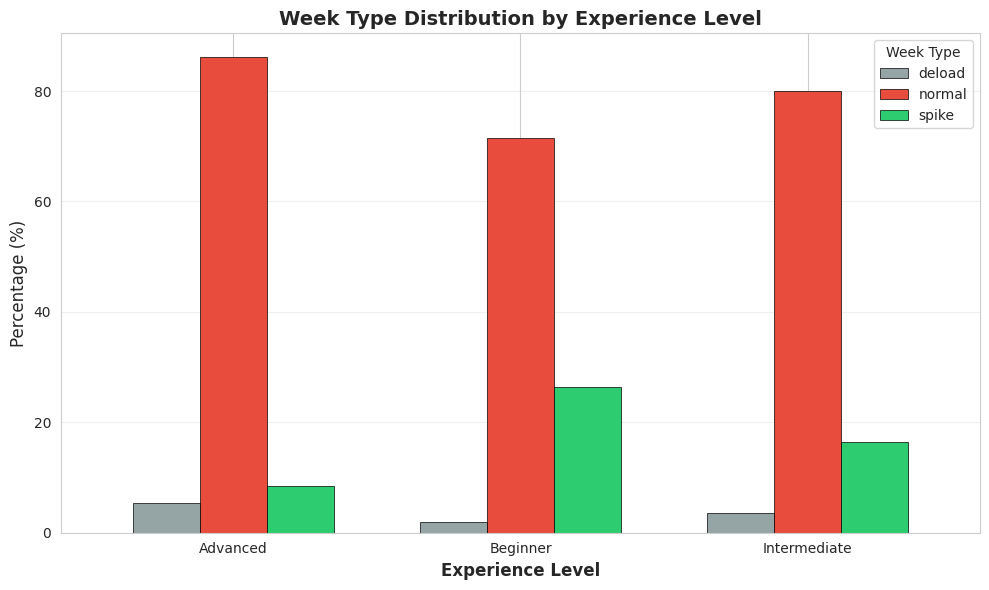

[OK] Week type plot saved

2. Skip Rate Analysis...

Skip Rate Statistics:

                   mean    std    min    max
experience_label                            
Advanced          0.070  0.017  0.035  0.117
Beginner          0.214  0.053  0.108  0.383
Intermediate      0.116  0.029  0.033  0.198


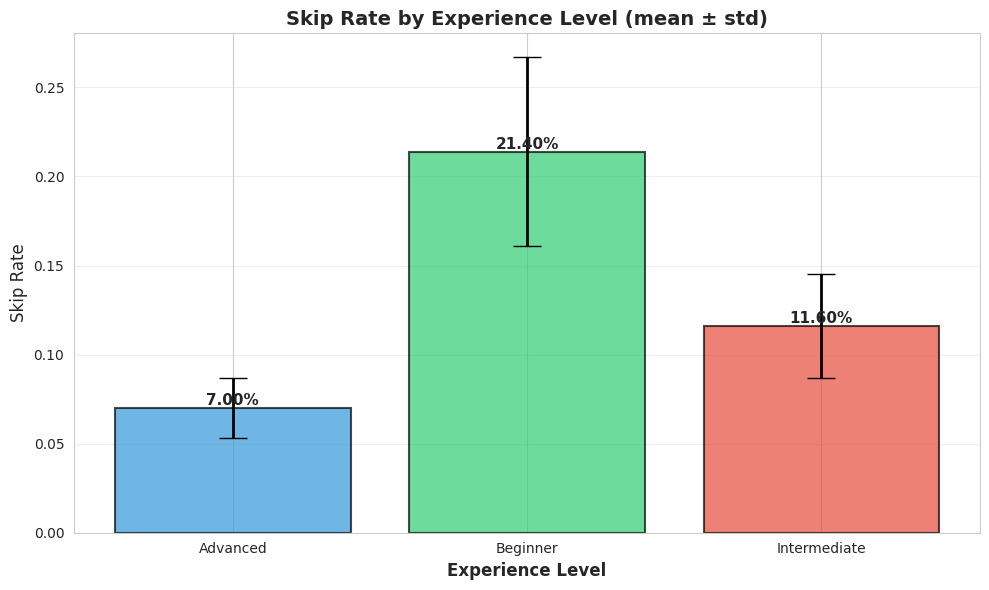

[OK] Skip rate plot saved

3. Total Sets Range Analysis...

Total Sets Distribution (%):

total_sets_bin    <500  500-1k  1k-2k  2k-4k  4k-8k   8k+
experience_label                                         
Advanced           0.0     0.0    2.4   25.3   47.1  25.3
Beginner          32.4    49.4   18.2    0.0    0.0   0.0
Intermediate       1.2     8.8   37.1   38.2   14.7   0.0


/tmp/ipython-input-1528294998.py:111: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sets_bin_dist = user_agg.groupby(['experience_label', 'total_sets_bin']).size().unstack(fill_value=0)


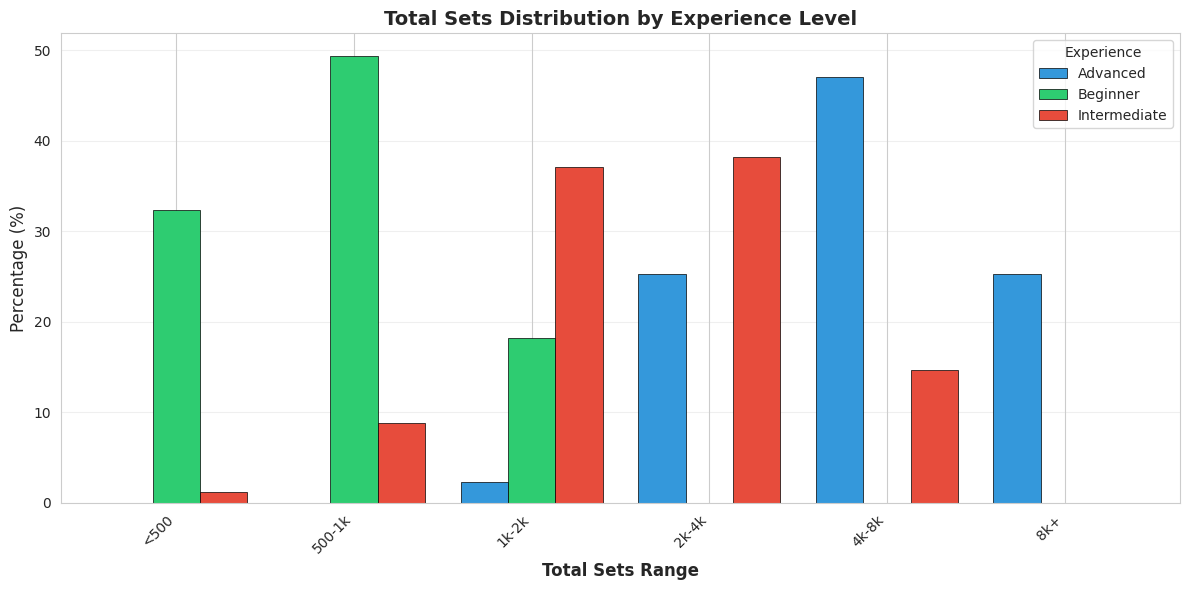

[OK] Total sets distribution plot saved

[OK] Categorical Analysis Complete


In [ ]:
# ═══════════════════════════════════════════════════════════
# CATEGORICAL ANALYSIS - Workout Patterns
# ═══════════════════════════════════════════════════════════

print("="*80)
print("CATEGORICAL ANALYSIS - Workout Patterns")
print("="*80)

# ════════════════════════════════════════════════════════════
# MERGE experience_label to df_sets (needed for analysis)
# ════════════════════════════════════════════════════════════

print("\nMerging experience_label to sets data...")

df_sets_with_exp = df_sets.merge(
    df_users[['user_id', 'experience_label']],
    on='user_id',
    how='left'
)

print(f"[OK] Merged: {len(df_sets_with_exp):,} sets with experience labels")

# ════════════════════════════════════════════════════════════
# 1. Week Type Distribution (spike/deload/normal)
# ════════════════════════════════════════════════════════════

print("\n1. Week Type Distribution by Experience...\n")

week_type_dist = df_sets_with_exp.groupby(['experience_label', 'week_type']).size().unstack(fill_value=0)
week_type_pct = week_type_dist.div(week_type_dist.sum(axis=1), axis=0) * 100

print("Week Type Distribution (%):\n")
print(week_type_pct.round(1))

# Grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
week_type_pct.plot(kind='bar', stacked=False, ax=ax,
                   color=['#95a5a6', '#e74c3c', '#2ecc71'],
                   width=0.7, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Experience Level', fontsize=12, weight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Week Type Distribution by Experience Level', fontsize=14, weight='bold')
ax.legend(title='Week Type', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('week_type_distribution_STATUS_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Week type plot saved")

# ════════════════════════════════════════════════════════════
# 2. Skip Rate Distribution
# ════════════════════════════════════════════════════════════

print("\n2. Skip Rate Analysis...\n")

skip_summary = user_agg.groupby('experience_label')['skip_rate'].agg([
    'mean', 'std', 'min', 'max'
]).round(3)

print("Skip Rate Statistics:\n")
print(skip_summary)

# Bar chart con error bars
fig, ax = plt.subplots(figsize=(10, 6))

x_pos = np.arange(len(skip_summary))
means = skip_summary['mean']
stds = skip_summary['std']

bars = ax.bar(x_pos, means, yerr=stds,
              color=['#3498db', '#2ecc71', '#e74c3c'],
              alpha=0.7, edgecolor='black', linewidth=1.5,
              capsize=10, error_kw={'linewidth': 2})

ax.set_xlabel('Experience Level', fontsize=12, weight='bold')
ax.set_ylabel('Skip Rate', fontsize=12)
ax.set_title('Skip Rate by Experience Level (mean ± std)', fontsize=14, weight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(skip_summary.index)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean_val) in enumerate(zip(bars, means)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean_val:.2%}',
            ha='center', va='bottom', fontsize=11, weight='bold')

plt.tight_layout()
plt.savefig('skip_rate_by_experience_STATUS_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Skip rate plot saved")

# ════════════════════════════════════════════════════════════
# 3. Total Sets Range Analysis
# ════════════════════════════════════════════════════════════

print("\n3. Total Sets Range Analysis...\n")

# Define bins (experience-aware)
bins = [0, 500, 1000, 2000, 4000, 8000, 15000]
labels = ['<500', '500-1k', '1k-2k', '2k-4k', '4k-8k', '8k+']

user_agg['total_sets_bin'] = pd.cut(user_agg['total_sets'], bins=bins, labels=labels)

sets_bin_dist = user_agg.groupby(['experience_label', 'total_sets_bin']).size().unstack(fill_value=0)
sets_bin_pct = sets_bin_dist.div(sets_bin_dist.sum(axis=1), axis=0) * 100

print("Total Sets Distribution (%):\n")
print(sets_bin_pct.round(1))

# Grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
sets_bin_pct.T.plot(kind='bar', ax=ax,
                    color=['#3498db', '#2ecc71', '#e74c3c'],
                    width=0.8, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Total Sets Range', fontsize=12, weight='bold')
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Total Sets Distribution by Experience Level', fontsize=14, weight='bold')
ax.legend(title='Experience', fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('total_sets_distribution_STATUS_v2.png', dpi=150, bbox_inches='tight')
plt.show()

print("[OK] Total sets distribution plot saved")

print("\n" + "="*80)
print("[OK] Categorical Analysis Complete")
print("="*80)
